In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc3 as pm


from ipywidgets import interact
import ipywidgets as ipyw

In [2]:
az.style.use('arviz-whitegrid')

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False"});

##### <center><img src="img/logo_inst.png" width="750">
<br>
<br>
<br>
<br>
<h1 align="center">Hierarchical models</h1>
    


<br>
<br>
<br>
<br>
<br>

## Hierarchical models

<center>
<img src="img/pooling.png" width=500>


<center>
<img src="img/hierarchical_model.png" width=500>

## Aims

* Learn how to build hierarchical models
* Discuss the concept of shrinkage and regularization
* ....

In [6]:
cs_data = pd.read_csv('../datos/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
idx = pd.Categorical(cs_data['aa']).codes
groups = len(np.unique(idx))

cs_data.tail()

,ID,aa,theo,exp
1771,1KS9,LYS,55.79,57.51
1772,1KS9,ARG,58.91,59.02
1773,1KS9,LYS,59.49,58.92
1774,1KS9,GLU,59.48,58.36
1775,1KS9,SER,58.07,60.55


In [7]:
with pm.Model() as cs_nh:         
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups) 
    σ = pm.HalfNormal('σ', sd=10, shape=groups) 
 
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff) 
     
    trace_cs_nh = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:04<00:00, 685.73draws/s] 


In [8]:
with pm.Model() as cs_h:
    # hyper_priors
    μ_mu = pm.Normal('μ_mu', mu=0, sd=10)
    μ_sd = pm.HalfNormal('μ_sd', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_mu, sd=μ_sd, shape=groups) 
    σ = pm.HalfNormal('σ', sd=10, shape=groups) 

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff) 

    trace_cs_h = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ, μ_sd, μ_mu]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:04<00:00, 638.19draws/s]


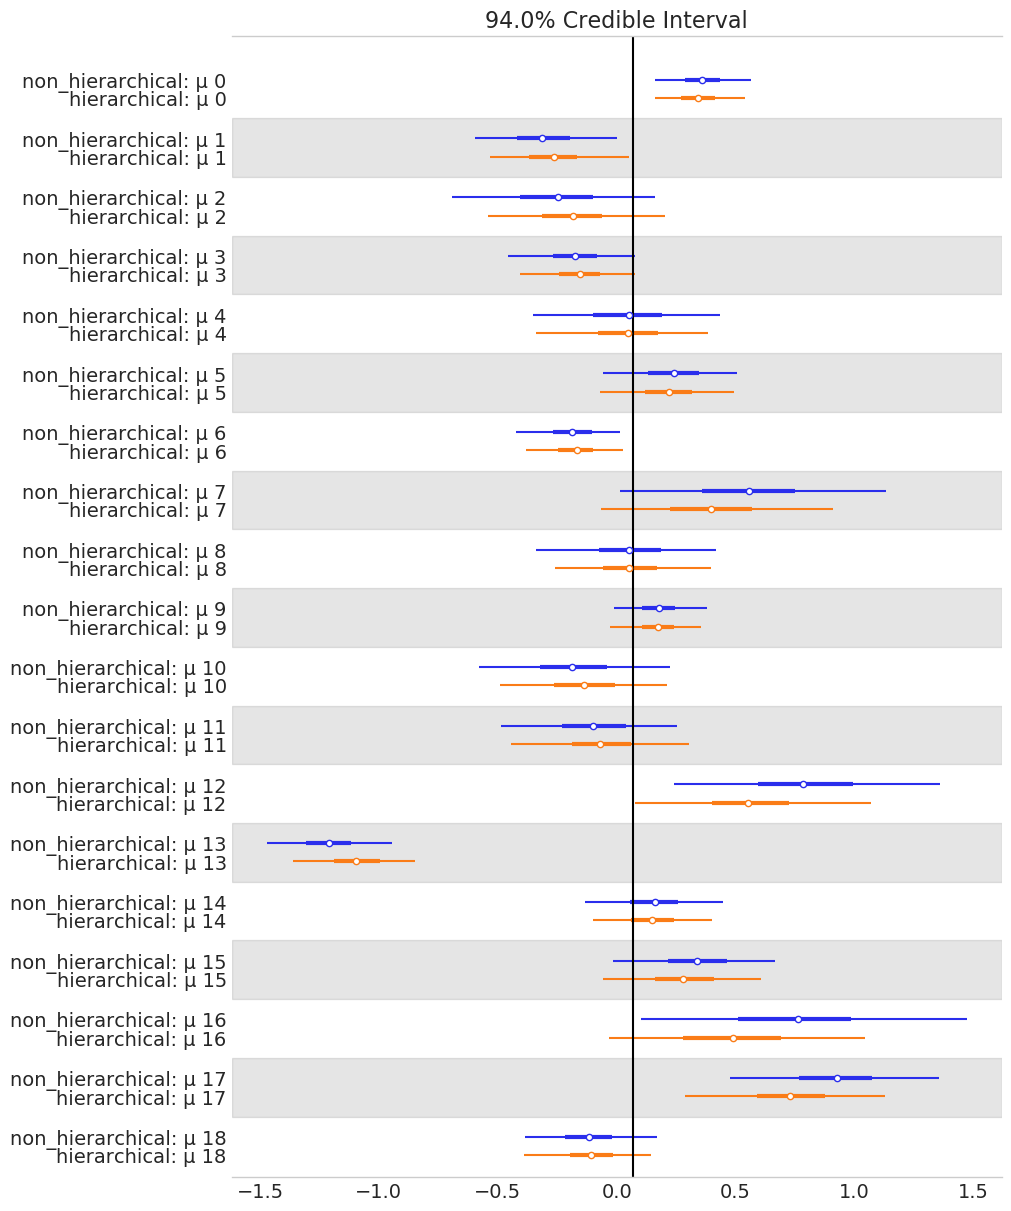

In [9]:
_, axes = az.plot_forest([trace_cs_nh, trace_cs_h], model_names=['non_hierarchical', 'hierarchical'],
              var_names='μ', combined=True, r_hat=False, ess=False, figsize=(10, 12),
              colors='cycle');
y_lims = axes[0].get_ylim()
axes[0].vlines(trace_cs_h['μ_mu'].mean(), *y_lims);

### Hierarchical coins

Non-hierarchical

\begin{align}
\theta &\sim \operatorname{Beta}(\alpha, \beta) \\
y &\sim \operatorname{Bin}(n=1, p=\theta)
\end{align}

Hierarchical

\begin{align}
\mu &\sim \operatorname{Beta}(\alpha, \beta) \\
\kappa &\sim \operatorname{Gamma}(s, r) \\
\theta &\sim \operatorname{Beta}(\alpha=\mu  \kappa, \beta=(1 - \mu)  \kappa) \\
y &\sim \operatorname{Bin}(n=1, p=\theta)
\end{align}


Graphically

<img src="img/modelo_3_monedas_jerarquico.png" width=250>

In [10]:
N =  [10, 10, 10]  # Número de experimentos por moneda
z =  [5, 5, 5]  # [1, 5, 9]  # Número de caras en los Ni experimentos.

# vector conteniendo los índices para cada moneda (desde 0 al número de monedas)
monedas = np.repeat(np.arange(len(N)), N)
# lista con 1 para caras y 0 para cecas
datos = []  
for i, experimentos in enumerate(N):
    datos.extend(np.repeat([1, 0], [z[i], N[i]-z[i]]))

* $\mu \sim \operatorname{Beta}(\alpha=2, \beta=2)$ -->  a distribution centered at 0.5 but very broad 
* $\kappa = \operatorname{Gamma}(s=1, r=0.1)$ -->  mean and standard deviation 10

In [11]:
with pm.Model() as modelo_j:
    # hiperparameters
    μ = pm.Beta('μ', alpha=2, beta=2)
    κ = pm.Gamma('κ', alpha=1, beta=0.1)
    #κ = pm.Gamma('κ', mu=10, sd=10)
    
    # definimos el a priori
    θ = pm.Beta('θ', μ * κ, (1 - μ) * κ, shape=len(N))
    # definimos el likelihood
    y = pm.Bernoulli('y', p=θ[monedas], observed=datos)

    # muestreamos
    trace_j = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ, κ, μ]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:04<00:00, 1026.31draws/s]
The acceptance probability does not match the target. It is 0.8848563784906787, but should be close to 0.8. Try to increase the number of tuning steps.


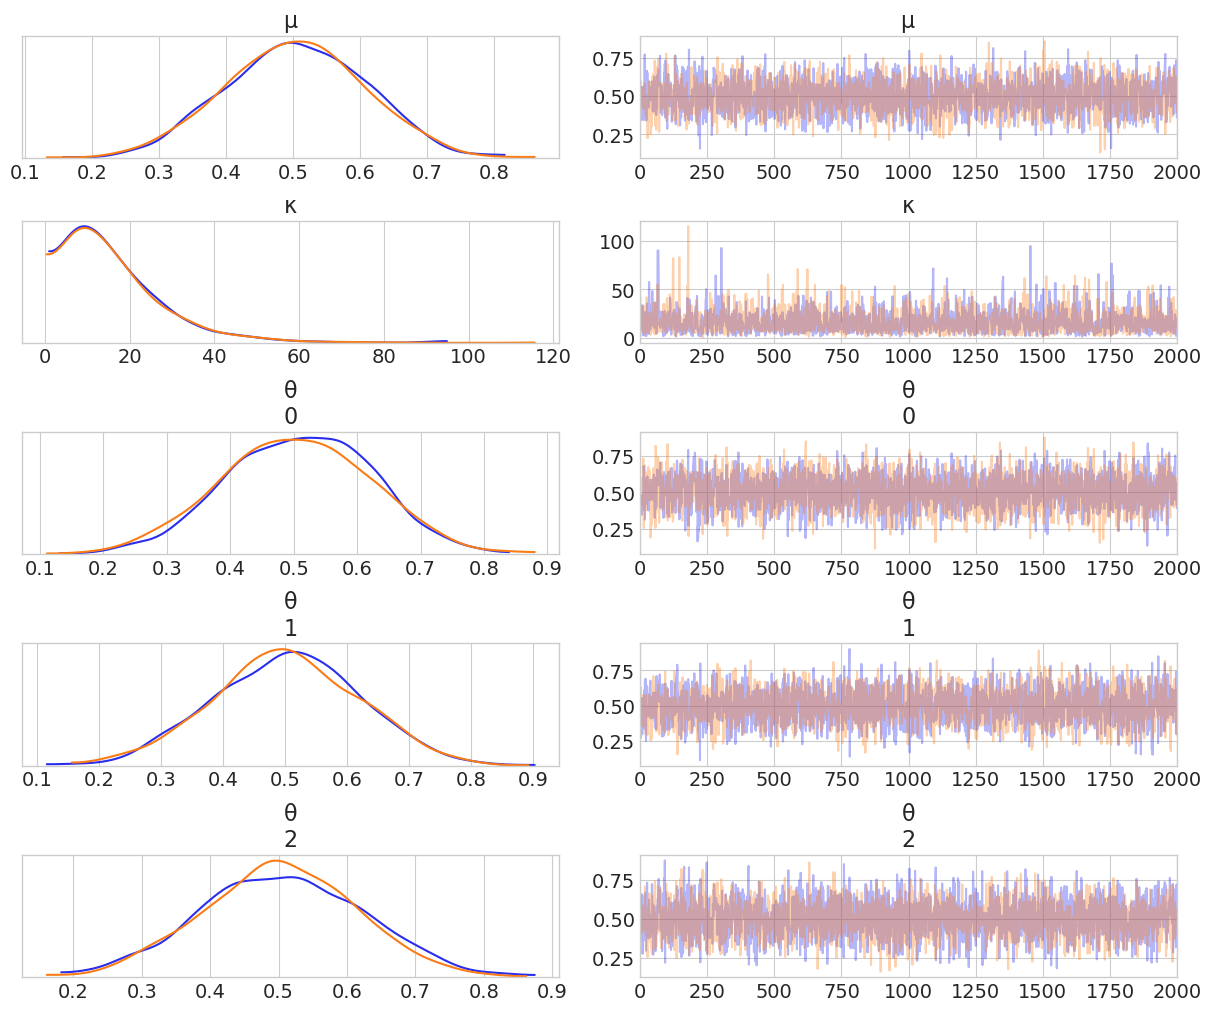

In [12]:
az.plot_trace(trace_j);

In [13]:
pm.summary(trace_j)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
μ,0.501500,0.102849,0.002104,0.308744,0.700663,2367.480150,0.999982
κ,16.337160,12.102830,0.294612,0.669677,39.469058,1880.107491,1.000068
θ__0,0.504610,0.115093,0.001982,0.286829,0.732339,3064.639180,1.000664
θ__1,0.500202,0.116422,0.002194,0.266496,0.716523,2647.064180,0.999861
θ__2,0.502181,0.114751,0.002063,0.277286,0.722080,2861.797520,1.000084


In [ ]:
### Contracción (_shrinking_)

Probemos ahora con otros ejemplos (puede ser conveniente guardar las figuras obtenidas con distintos nombres).

* z = [1,1,1] 
* z = [9,9,9] 
* z = [9,1,9]

## Advantages of hierarchical models

<br>

* Regularization:
    * Improved estimates for repeat sampling
    * Improved estimates for imbalance in sampling
  
* Estimates of variation among groups.

* Avoid averaging, retain variation.

<br>